In [1]:
import os # 파일 시스템 작업
import numpy as np # 수치 연산
from tensorflow.keras.preprocessing.image import load_img, img_to_array # 이미지 파일 로드, 이미지 넘파일 배열로 변환
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization # 신경망 모델 구성 함수 및 클래스
from sklearn.model_selection import train_test_split # 데이터를 훈련 세트와 테스트 세트로 분리하는 함수

2024-05-19 21:18:46.878577: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 21:18:46.879729: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 21:18:46.902746: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 21:18:46.903324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 21:18:47.258801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [ ]:
# 이미지 파일명에서 롤과 피치 값을 파싱하는 함수

In [2]:
def parse_roll_pitch(filename):
    try:
        # filename을 '_' 기준으로 분할하여 리스트로 만듦
        parts = filename.split('_')
        # 'roll'과 'pitch' 문자열을 찾고, 이후의 문자열(음수 포함)을 실수로 변환
        roll_str = [part for part in parts if 'roll' in part][0]
        pitch_str = [part for part in parts if 'pitch' in part][0]
        # 'roll'과 'pitch' 문자열에서 숫자 부분만 추출하여 실수로 변환
        roll = float(roll_str.replace('roll', ''))
        pitch = float(pitch_str.replace('pitch', ''))
        return roll, pitch
    except ValueError as e:
        print(f"Error processing file {filename}: {e}")
        # 오류가 발생한 경우 기본값 반환
        return 0.0, 0.0

In [ ]:
# 데이터 로드 향상을 위해 이미지 사이즈를 줄이고 멀티스레딩으로 이미지 로드

In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# 이미지 로드 함수
def load_image(image_path, img_size=(224, 224)):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# 데이터셋 로드 함수
def load_dataset(dataset_dir, img_size=(224, 224)):
    x, y = [], []
    image_paths = []

    # 모든 하위 디렉토리를 포함하여 지정된 경로에서 파일 순회
    for root, dirs, files in os.walk(dataset_dir):
        for filename in files:
            if filename.endswith('.png'):  # .png 파일만 처리
                img_path = os.path.join(root, filename)
                image_paths.append((img_path, filename))

    # 멀티스레딩으로 이미지 로드
    with ThreadPoolExecutor() as executor: # 멀티스레딩 환경 생성
        future_to_image = {executor.submit(load_image, path, img_size): filename for path, filename in image_paths} # load_image 함수를 비동기적으로 실행하며, 각 작업에 대한 Future 객체와 파일명을 매핑
        for future in tqdm(as_completed(future_to_image), total=len(future_to_image), desc="Loading images"): # as_completed 함수를 사용하여 각 Future 객체가 완료될 때까지 기다리고, tqdm을 통해 진행 상황을 표시
            filename = future_to_image[future] # 완료된 Future 객체에 해당하는 파일명을 가짐
            try:
                img_array = future.result()
                roll, pitch = parse_roll_pitch(filename)
                x.append(img_array)
                y.append([roll, pitch])
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    return np.array(x), np.array(y)

In [ ]:
# 데이터 로드 - 데이터 셋이 저장되어 있다는 전재로 해야 함

In [4]:
dataset_path = 'DATASET_Study'
x, y = load_dataset(dataset_path)

Loading images: 100%|████████████████████| 13447/13447 [01:05<00:00, 206.04it/s]


In [ ]:
# 데이터의 크기 확인

In [5]:
print(f'x shape: {np.array(x).shape}')
print(f'y shape: {np.array(y).shape}')

x shape: (13447, 224, 224, 3)
y shape: (13447, 2)


In [ ]:
# 테스트 데이터셋을 전체 데이터의 20%로 설정

In [6]:
test_size = 0.2 # 테스트 데이터셋을 전체 데이터의 20%로 설정
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

In [ ]:
# 데이터 train과 test 데이터셋의 크기 확인

In [7]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (13446, 224, 224, 3)
y_train shape: (13446, 2)
x_test shape: (3362, 224, 224, 3)
y_test shape: (3362, 2)


In [ ]:
# CNN 모델 구성 - 기본 모델

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)  # 롤과 피치 출력
])

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# 모델 훈련
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

# 모델 저장
model.save('Reserch/model.keras')

Epoch 1/10
269/269 [==============================] - 74s 274ms/step - loss: 35.5248 - mae: 3.3051 - val_loss: 0.9243 - val_mae: 0.7591
Epoch 2/10
269/269 [==============================] - 71s 263ms/step - loss: 0.4880 - mae: 0.5418 - val_loss: 0.3765 - val_mae: 0.4760
Epoch 3/10
269/269 [==============================] - 69s 257ms/step - loss: 0.3305 - mae: 0.4456 - val_loss: 0.3676 - val_mae: 0.4908
Epoch 4/10
269/269 [==============================] - 71s 264ms/step - loss: 0.2625 - mae: 0.4008 - val_loss: 0.1944 - val_mae: 0.3417
Epoch 5/10
269/269 [==============================] - 74s 275ms/step - loss: 0.2164 - mae: 0.3641 - val_loss: 0.1813 - val_mae: 0.3263
Epoch 6/10
269/269 [==============================] - 70s 261ms/step - loss: 0.1595 - mae: 0.3137 - val_loss: 0.1395 - val_mae: 0.2944
Epoch 7/10
269/269 [==============================] - 72s 268ms/step - loss: 0.1279 - mae: 0.2796 - val_loss: 0.2387 - val_mae: 0.3824
Epoch 8/10
269/269 [==============================] - 

In [ ]:
# 테스트 데이터 셋을 사용하여 모델 평가

In [8]:
test_loss, test_mae = model.evaluate(x_test, y_test)

# 평가 결과 출력
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

85/85 [==============================] - 4s 52ms/step - loss: 0.0942 - mae: 0.2392
Test Loss: 0.0942474901676178
Test MAE: 0.23916804790496826


In [ ]:
# Performance Metrics - 실행이 안되면 r2를 다 빼고 해보기

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# 예측을 배치로 수행하여 메모리 문제 해결
batch_size = 32 #적절한 배치 크기로 설정
predictions = model.predict(x_test, batch_size=batch_size)

predictions = model.predict(x_test)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# MAE 계산
mae = mean_absolute_error(y_test, predictions)

# MAPE 계산 - 실제값이 0인 경우를 처리해야 하므로 이 부분을 추가
mape_values = np.abs((y_test - predictions) / y_test)
mape_values = mape_values[~np.isinf(mape_values) & ~np.isnan(mape_values)]
mape = np.mean(mape_values) * 100

# R^2 스코어
r2 = r2_score(y_test, predictions)
print(f"R-squared Score: {r2}")

# 성능 지표를 데이터프레임으로 저장
performance_metrics_df = pd.DataFrame({
    'Models': ['Your Model'],
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape],
    'R-squared Score': [r2]
})

# 결과를 데이터프레임으로 출력
performance_metrics_df

85/85 [==============================] - 4s 51ms/step
R-squared Score: 0.999329776634429


/tmp/ipykernel_20271/741353025.py:17: RuntimeWarning: divide by zero encountered in divide
  mape_values = np.abs((y_test - predictions) / y_test)


,Models,RMSE,MAE,MAPE,R-squared Score
0,Your Model,0.306998,0.239168,4.360125,0.99933


In [10]:
# 테스트 데이터셋에 대한 예측 수행
y_pred = model.predict(x_test)

# roll과 pitch에 대한 MAE 계산
mae_roll = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_pitch = mean_absolute_error(y_test[:, 1], y_pred[:, 1])

print(f"Mean Absolute Error for Roll: {mae_roll}")
print(f"Mean Absolute Error for Pitch: {mae_pitch}")

85/85 [==============================] - 4s 52ms/step
Mean Absolute Error for Roll: 0.2299396156980812
Mean Absolute Error for Pitch: 0.24839654478995774


In [ ]:
# 테스트 값 정확도 출력 (-> 굳이 사용할 필요없지만 참고)

In [11]:
# y_test가 1차원 배열일 경우, 모든 값이 0이 아닌 경우만 고려
if y_test.ndim == 1:
    non_zero_indices = np.where(y_test != 0)[0]
# y_test가 2차원 배열일 경우, 모든 행에 대해 하나라도 0이 아닌 경우를 고려
else:
    non_zero_indices = np.where(np.any(y_test != 0, axis=1))[0]

# 0이 아닌 실제 값에 대한 예측 값과의 절대적인 차이 계산
absolute_differences = np.abs(predictions[non_zero_indices] - y_test[non_zero_indices])

# 0이 아닌 실제 값에 대한 차이의 백분율 계산
# 실제 값이 0인 경우에는 오차를 계산하지 않음
valid_indices = y_test[non_zero_indices] != 0
percentage_errors = np.where(
    valid_indices,
    100 * absolute_differences / np.abs(y_test[non_zero_indices]),
    0
)

# "정확도"를 나타내는 지표를 계산 (100%에서 오차를 뺀 값)
accuracy_like_scores = 100 - np.mean(percentage_errors, axis=0)

# 롤과 피치 각각에 대한 "정확도" 출력
print(f"Roll Accuracy-like Score: {accuracy_like_scores[0]:.2f}%")
print(f"Pitch Accuracy-like Score: {accuracy_like_scores[1]:.2f}%")

Roll Accuracy-like Score: 96.41%
Pitch Accuracy-like Score: 95.08%


/tmp/ipykernel_20271/2844254232.py:16: RuntimeWarning: divide by zero encountered in divide
  100 * absolute_differences / np.abs(y_test[non_zero_indices]),


In [ ]:
# 훈련 결과 그래프 - 기본

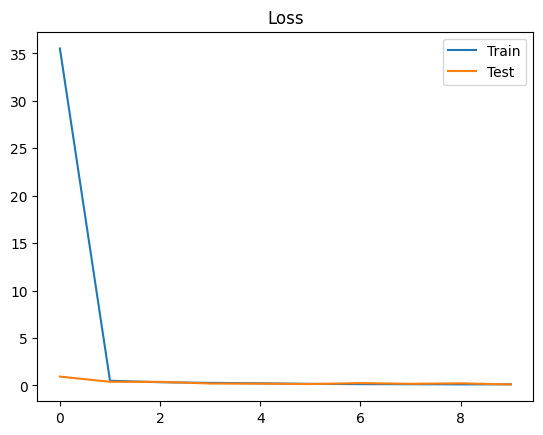

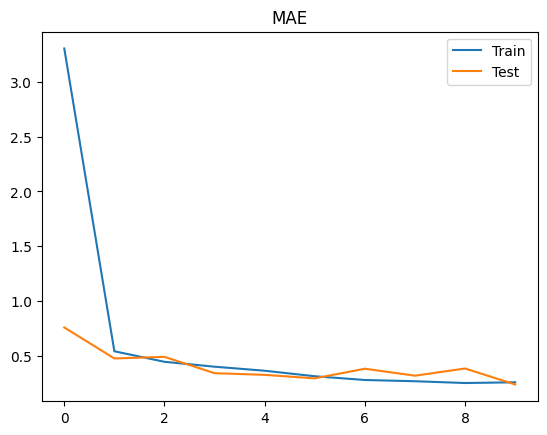

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# 훈련 손실과 검증 손실 시각화
#plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 MAE와 검증 MAE 시각화
#plt.figure(figsize=(10, 4))
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Test')
plt.title('MAE')
#plt.xlabel('Epoch')
#plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# 훈련 결과 그래프 - 이상치 제거 및 그리드 추가

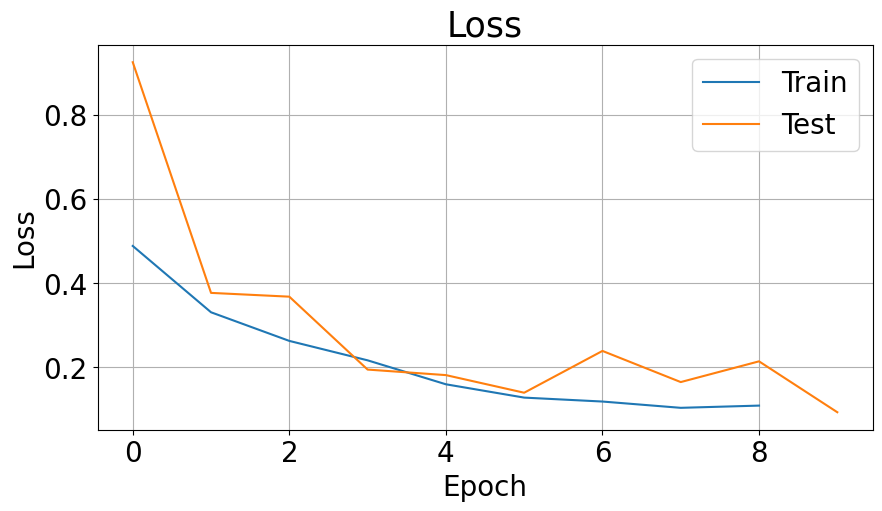

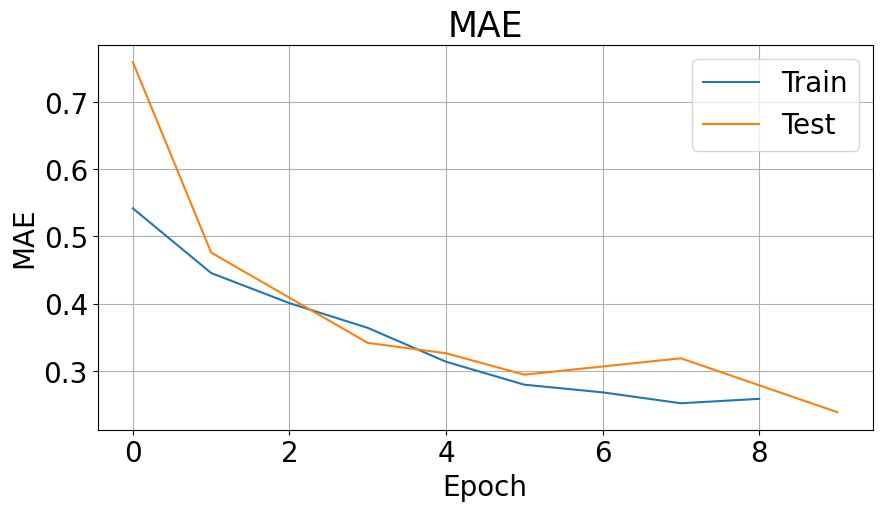

In [13]:
# 'history.history'에서 'loss'와 'val_loss', 'mae'와 'val_mae'를 가져옴
# 이 예에서는 임의의 값으로 배열을 생성합니다. 실제로는 훈련 과정에서 얻은 값들을 사용해야 함
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
mae = np.array(history.history['mae'])
val_mae = np.array(history.history['val_mae'])

def outlier_detection(data):
    for i in range(1, len(data) - 1):  # 첫 번째와 마지막 값은 제외하고 반복
        # 양 옆 값에 비해 현재 값이 이상치인지 확인
        if data[i] > data[i - 1] * 1.5 and data[i] > data[i + 1] * 1.5:
            # 이상치를 양 옆 값의 평균으로 대체합니다.
            data[i] = (data[i - 1] + data[i + 1]) / 2
    return data

def outlier_detection2(data):
    for i in range(1, len(data) - 1):  # 첫 번째와 마지막 값은 제외하고 반복
        # 양 옆 값에 비해 현재 값이 이상치인지 확인
        if data[i] > data[i - 1] * 1 and data[i] > data[i + 1] * 1:
            # 이상치를 양 옆 값의 평균으로 대체
            data[i] = (data[i - 1] + data[i + 1]) / 2
    return data

# 'loss'와 'val_loss' 배열에서 이상치 대체
loss = outlier_detection(loss)
val_loss = outlier_detection(val_loss)

mae = outlier_detection2(mae)
val_mae = outlier_detection2(val_mae)

Title_Size = 25
Size = 20

# 손실 그래프
plt.figure(figsize=(10, 5))
plt.rc('font', size=Size)    
plt.rc('xtick', labelsize=Size)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=Size)  # y축 눈금 폰트 크기
plt.plot(loss[1:], label='Train')
plt.plot(val_loss, label='Test')
plt.title('Loss',fontsize=Title_Size)
plt.xlabel('Epoch', fontsize=Size)
plt.ylabel('Loss', fontsize=Size)
plt.legend(fontsize=Size)
plt.grid(True)
plt.show()

# MAE 그래프
plt.figure(figsize=(10, 5))
plt.plot(mae[1:], label='Train')
plt.plot(val_mae, label='Test')
plt.title('MAE', fontsize=Title_Size)
plt.xlabel('Epoch', fontsize=Size)
plt.ylabel('MAE', fontsize=Size)
plt.legend(fontsize=Size)
plt.grid(True)
plt.show()

In [ ]:
# 이미지 처리

In [ ]:
# 이미지 파일 경로
image_path = 'DATASET2/dataset_11_240205/pitch-10_roll0_184022.png'

# 이미지 로드 및 전처리
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # 이미지를 0에서 1로 정규화

# 모델을 사용하여 롤과 피치 값을 예측
predictions = model.predict(np.expand_dims(img_array, axis=0))

# 예측 결과 출력
print("Predicted Roll:", predictions[0][0])
print("Predicted Pitch:", predictions[0][1])

In [ ]:
# 실제 이미지에서 예측값 확인

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 모델로부터 롤과 피치 값 예측 함수
def predict_roll_pitch(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # 모델 입력을 위해 차원 확장

    # 모델 예측
    predicted_roll_pitch = model.predict(img_array)
    return predicted_roll_pitch[0]  # 첫 번째 예측 결과 반환

# 영상에 롤과 피치 값 표시
def draw_roll_pitch_on_image(image_path, model):
    # 이미지 로드
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # matplotlib에서는 RGB 포맷을 사용

    # 모델을 사용하여 롤과 피치 값 예측
    predicted_roll, predicted_pitch = predict_roll_pitch(model, image_path)

    # 표시할 텍스트 준비
    text = f"Roll: {predicted_roll:.2f}, Pitch: {predicted_pitch:.2f}"

    # 영상에 텍스트 표시
    plt.imshow(img_rgb)
    plt.text(10, 30, text, color='green', fontsize=12)
    plt.axis('off')  # 축 표시 제거
    plt.show()

# 사용법
image_path = 'DATASET2/dataset_2_240205/pitch-2_roll-10_161603.png'  # 실제 이미지 경로로 수정
draw_roll_pitch_on_image(image_path, model)  # 'model'은 1단계에서 훈련된 모델 인스턴스

In [ ]:
# Case Study 1 - 학습한 모델에 다른 데이터 셋 넣었을 때 결과

In [15]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 새로운 테스트 데이터셋 디렉토리
new_test_dataset_path = 'DATASET/dataset_10_240205'

# 새로운 테스트 데이터셋 로드 (이 함수의 구현이 필요합니다)
x_new_test, y_new_test = load_dataset(new_test_dataset_path)

# 훈련된 모델 불러오기
model = load_model('Reserch/model.keras')

# 새로운 테스트 데이터셋에 대한 예측 수행
predictions = model.predict(x_new_test)

# 성능 평가
mse = mean_squared_error(y_new_test, predictions)
mae = mean_absolute_error(y_new_test, predictions)

print(f"Mean Squared Error (MSE) on new test set: {mse}")
print(f"Mean Absolute Error (MAE) on new test set: {mae}")

Loading images: 100%|██████████████████████| 1681/1681 [00:11<00:00, 148.55it/s]


53/53 [==============================] - 3s 52ms/step
Mean Squared Error (MSE) on new test set: 8.358876864786108
Mean Absolute Error (MAE) on new test set: 2.2942391283748362


In [ ]:
# Case Study 1 - Roll, Pitch에 대한 MAE 값

In [16]:
# Roll, Pitch에 대한 MAE 계산
mae_roll = mean_absolute_error(y_new_test[:, 0], predictions[:, 0])
mae_pitch = mean_absolute_error(y_new_test[:, 1], predictions[:, 1])

print(f"Mean Absolute Error (MAE) for Roll: {mae_roll:.4f}")
print(f"Mean Absolute Error (MAE) for Pitch: {mae_pitch:.4f}")

Mean Absolute Error (MAE) for Roll: 1.3956
Mean Absolute Error (MAE) for Pitch: 3.1929
